# Modular COPD Modeling Pipeline
This notebook is a refactored version of the full pipeline. Each step is wrapped in modular functions, cleaned of redundancy, and ready for reuse or publication.

In [1]:
def load_and_clean_data(path='merged_burden_risk.csv'):
    import pandas as pd
    df = pd.read_csv(path)
    df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
    df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
    df = df.sort_values(by=['country', 'year'])
    return df

In [2]:
def apply_basic_features(df):
    import numpy as np
    # df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
    df['log_population_density'] = np.log(df['Population Density'] + 1)
    df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
    df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
    df['no2_per_capita'] = df['Nitrogen Oxide'] / df['Population']
    df['black_carbon_per_capita'] = df['Black Carbon'] / df['Population']
    df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
    df['year_index'] = df['year'] - df['year'].min()
    df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1)
    return df

In [3]:
def apply_advanced_features(df):
    df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['dalys_3yr_avg'] = df.groupby('country')['DALYs'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
    df['delta_black_carbon'] = df.groupby('country')['Black Carbon'].diff()
    df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
    df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
    df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df['lagged_dalys']
    df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])
    return df

In [4]:
def prepare_model_data(df):
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    feature_cols = ['log_gdp_per_capita', 'log_population_density', 'log_total_co2',
                    'co2_per_capita', 'pollution_x_low_haq', 'year_index', 'lagged_dalys',
                    'pm25_3yr_avg', 'delta_pm25', 'gdp_x_haq', 'smoking_x_pm25',
                    'haq_x_dalys_lag', 'vulnerability_index']
    df_model = df.dropna(subset=feature_cols + ['DALYs']).copy()
    X = df_model[feature_cols]
    y = df_model['DALYs']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42), feature_cols

In [5]:
def evaluate_models(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import Ridge, Lasso, QuantileRegressor, LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    import xgboost as xgb
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    import pandas as pd
    import numpy as np

    models = {
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Quantile Regression (median)': QuantileRegressor(quantile=0.5, alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        'Linear Regression' : LinearRegression()
    }

    results = []

    mean_dalys = y_test.mean()
    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # for name, model in models.items():
    #     model.fit(X_train, y_train)
    #     preds = model.predict(X_test)
    #     rmse_pct = rmse / mean_dalys
    #     results.append({
    #         'Model': name,
    #         'R²': r2_score(y_test, preds),
    #         'MAE': mean_absolute_error(y_test, preds),
    #         'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
    #         'Mean DALYs': mean_dalys,
    #         'RMSE as % of Mean DALYs': f"{rmse_pct:.2%}"
            
    #     })

    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        rmse_pct = rmse / mean_dalys

        results.append({
            'Model': name,
            'R²': r2,
            'MAE': mae,
            'RMSE': rmse,
            'Mean DALYs': mean_dalys,
            'RMSE as % of Mean DALYs': f"{rmse_pct:.2%}"

        })

    return pd.DataFrame(results).sort_values(by='R²', ascending=False)

In [6]:
def shap_explain(xgb_model, X_train, X_test, feature_cols):
    import shap
    import matplotlib.pyplot as plt
    explainer = shap.Explainer(xgb_model, X_train)
    shap_values = explainer(X_test)
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols, show=False)
    plt.tight_layout()
    plt.show()

In [7]:
def ridge_lasso_coefficients(X_train, y_train, feature_cols):
    from sklearn.linear_model import Ridge, Lasso
    import pandas as pd
    ridge = Ridge(alpha=1.0).fit(X_train, y_train)
    lasso = Lasso(alpha=0.1).fit(X_train, y_train)
    ridge_coef = pd.Series(ridge.coef_, index=feature_cols)
    lasso_coef = pd.Series(lasso.coef_, index=feature_cols)
    return pd.DataFrame({
        'Ridge Coefficient': ridge_coef,
        'Lasso Coefficient': lasso_coef
    }).sort_values(by='Ridge Coefficient', key=abs, ascending=False)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_quantile.py:186: FutureWarning: The default solver will change from 'interior-point' to 'highs' in version 1.4. Set `solver='highs'` or to the desired solver to silence this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_quantile.py:297: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
The solution does not satisfy the constraints within the required tolerance of 3.16E-04, yet no errors were raised and there is no certificate of infeasibility or unboundedness. Check whether the slack and constraint residuals are acceptable; if not, consider enabling presolve, adjusting the tolerance option(s), and/or using a different method. Please consider submitting a bug report.
  warnings.warn(


                          Model        R²          MAE          RMSE  \
2  Quantile Regression (median)  0.999783   356.137735    450.407240   
5             Linear Regression  0.999526   540.611793    665.685599   
1              Lasso Regression  0.999497   550.768091    685.595520   
0              Ridge Regression  0.963082  4569.002934   5874.711065   
4                       XGBoost  0.953308  4326.898633   6606.771258   
3                 Random Forest  0.864299  7388.048000  11263.162791   

   Mean DALYs RMSE as % of Mean DALYs  
2     50154.4                   0.90%  
5     50154.4                   1.33%  
1     50154.4                   1.37%  
0     50154.4                  11.71%  
4     50154.4                  13.17%  
3     50154.4                  22.46%  


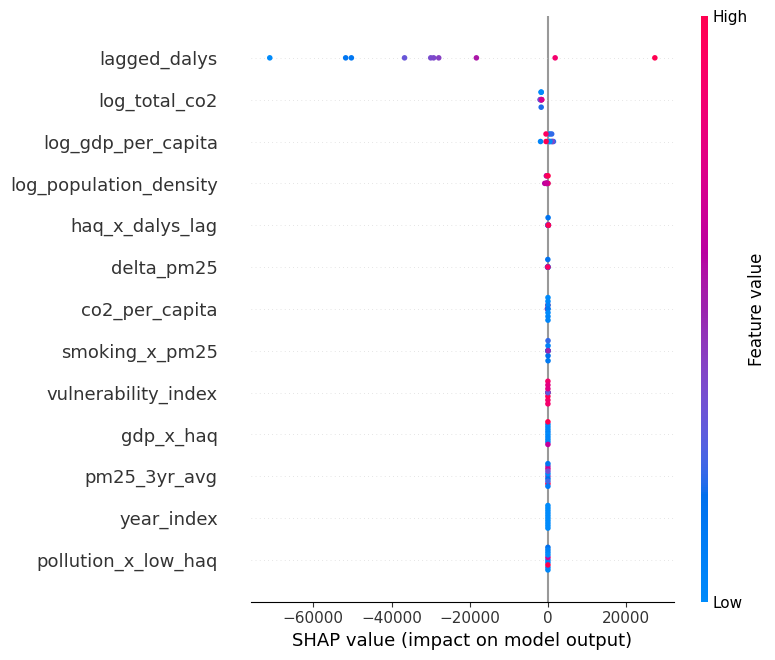

,Ridge Coefficient,Lasso Coefficient
lagged_dalys,61490.915782,95181.946271
haq_x_dalys_lag,27811.130731,-1224.398622
co2_per_capita,-6958.695069,2731.818684
pm25_3yr_avg,6614.291187,1525.641941
gdp_x_haq,5880.409637,-90.422048
delta_pm25,-4514.398741,1859.442043
log_total_co2,3636.639845,-373.982679
vulnerability_index,3454.714789,367.631902
smoking_x_pm25,-2787.706556,-2216.262265
log_gdp_per_capita,-1203.927971,583.264390


In [8]:
# Run full pipeline
df = load_and_clean_data()
df = apply_basic_features(df)
df = apply_advanced_features(df)
(X_train, X_test, y_train, y_test), feature_cols = prepare_model_data(df)
model_results = evaluate_models(X_train, X_test, y_train, y_test)
print(model_results)

# SHAP Explainability for XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
shap_explain(xgb_model, X_train, X_test, feature_cols)

# Ridge vs Lasso
coeffs = ridge_lasso_coefficients(X_train, y_train, feature_cols)
coeffs

In [ ]:
# Step 6A: Prepare panel data and run Fixed Effects model on DALYs using linearmodels

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm

# Reload the dataset and ensure it's sorted
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

# Feature engineering for panel model
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['year_index'] = df['year'] - df['year'].min()
df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df['lagged_dalys']
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# Set index for panel structure
df = df.set_index(['country', 'year'])

# Select variables for model
panel_features = [
    'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index'
]
panel_df = df[panel_features + ['DALYs']].dropna()

# Add constant for regression
panel_df = panel_df.copy()
panel_df['const'] = 1

# Fit Fixed Effects model
fe_model = PanelOLS(dependent=panel_df['DALYs'],
                    exog=panel_df[['const'] + panel_features],
                    entity_effects=True)

fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)
fe_summary = fe_results.summary.tables[1]

# Convert results to DataFrame for display
summary_df = pd.read_html(fe_summary.as_html(), header=0, index_col=0)[0]
import ace_tools as tools; tools.display_dataframe_to_user(name="Fixed Effects Regression Results (DALYs)", dataframe=summary_df)

summary_df


In [ ]:
from linearmodels.panel import PanelOLS

fe_model = PanelOLS(dependent=panel_df['DALYs'],
                    exog=panel_df[['const'] + panel_features],
                    entity_effects=True)
fe_results = fe_model.fit(cov_type='clustered', cluster_entity=True)
print(fe_results.summary)

In [ ]:
Panel Modeling — Random Effects Approximation (OLS + Clustered SE)
# STEP 6A: Random Effects-style Panel Regression (with Clustered SEs)

import pandas as pd
import numpy as np
import statsmodels.api as sm

# === 1. Load and clean the dataset ===
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

# === 2. Feature Engineering for panel model ===
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['year_index'] = df['year'] - df['year'].min()
df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df['lagged_dalys']
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# === 3. Select features for modeling ===
panel_features = [
    'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index'
]
panel_df = df[['country', 'year'] + panel_features + ['DALYs']].dropna()

# === 4. Add constant and define inputs ===
X = sm.add_constant(panel_df[panel_features])
y = panel_df['DALYs']

# === 5. Fit the model with cluster-robust SEs (Random Effects approximation) ===
model = sm.OLS(y, X)
re_results = model.fit(cov_type='cluster', cov_kwds={'groups': panel_df['country']})

# === 6. Print results summary ===
print(re_results.summary())
# 📘 Notes:

# This approximates Random Effects by clustering standard errors by country
# It controls for within-country correlation while pooling across countries
# For true RE, you can use linearmodels.RandomEffects() if you're set up for that
Would you like me to also give you the First-Difference model version next?





In [ ]:
# STEP 6A-2: First-Difference Panel Regression

import pandas as pd
import numpy as np
import statsmodels.api as sm

# === 1. Load and prep dataset ===
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

# === 2. Feature Engineering ===
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df.groupby('country')['DALYs'].shift(1)
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# === 3. Select final features and drop NA ===
features = [
    'DALYs', 'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index'
]
df_sub = df[['country', 'year'] + features].dropna()

# === 4. Group by country and apply first differences ===
df_diff = df_sub.groupby('country').apply(lambda x: x.set_index('year').diff()).dropna().reset_index()

# Reattach country ID
df_diff['country'] = df_sub.groupby('country').apply(lambda x: x.iloc[1:]['country'].values).explode().values

# === 5. Define inputs and model ===
X_diff = sm.add_constant(df_diff[['log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
                                  'gdp_x_haq', 'smoking_x_pm25', 'haq_x_dalys_lag', 'vulnerability_index']])
y_diff = df_diff['DALYs']

# === 6. OLS with cluster-robust SE (by country) ===
model_diff = sm.OLS(y_diff, X_diff)
fd_results = model_diff.fit(cov_type='cluster', cov_kwds={'groups': df_diff['country']})

# === 7. Print summary ===
print(fd_results.summary())


In [ ]:
Here is the complete and cleaned code to run both the Random Effects-style and First-Difference panel regressions using "deaths" as the target outcome.

✅ Panel Models for deaths

# STEP 6A EXTENSION: Panel Regression on COPD Deaths

import pandas as pd
import numpy as np
import statsmodels.api as sm

# === 1. Load and Prepare Dataset ===
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['deaths'])  # use exact column name
df.rename(columns={'deaths': 'TARGET'}, inplace=True)
df = df.sort_values(by=['country', 'year'])

# === 2. Feature Engineering (Static) ===
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_target_lag'] = df['HAQ_Index'].fillna(0) * df.groupby('country')['TARGET'].shift(1)
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

# === 3. Select Features and Drop Missing ===
features = [
    'TARGET', 'log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
    'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index'
]
df_sub = df[['country', 'year'] + features].dropna()

# === 4. RANDOM EFFECTS-STYLE MODEL (Clustered OLS) ===
X = sm.add_constant(df_sub[['log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
                            'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index']])
y = df_sub['TARGET']
re_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': df_sub['country']})
print("🔹 RANDOM EFFECTS MODEL RESULTS FOR DEATHS")
print(re_model.summary())

# === 5. FIRST-DIFFERENCE MODEL ===
df_diff = df_sub.groupby('country').apply(lambda x: x.set_index('year').diff()).dropna().reset_index()
df_diff['country'] = df_sub.groupby('country').apply(lambda x: x.iloc[1:]['country'].values).explode().values
X_diff = sm.add_constant(df_diff[['log_gdp_per_capita', 'pollution_x_low_haq', 'pm25_3yr_avg',
                                  'gdp_x_haq', 'smoking_x_pm25', 'haq_x_target_lag', 'vulnerability_index']])
y_diff = df_diff['TARGET']
fd_model = sm.OLS(y_diff, X_diff).fit(cov_type='cluster', cov_kwds={'groups': df_diff['country']})
print("\n🔹 FIRST-DIFFERENCE MODEL RESULTS FOR DEATHS")
print(fd_model.summary())

In [ ]:
#### Interpretation Guidance

 # After running:

 # Focus on sign and magnitude of:
# pollution_x_low_haq
# pm25_3yr_avg
# smoking_x_pm25
# These represent how structural pollution exposure and health system quality affect mortality 

In [ ]:
# Final robust, dynamic SARIMAX forecasting module with enhancements included step 6b

def forecast_copd_country_robust(
    df,
    country: str,
    target_column: str,
    exog_columns: list,
    forecast_years: int = 9,
    arima_order=(1, 1, 1),
    simulate_growth: dict = None,
    display_plot: bool = True
):
    """
    Robust SARIMAX forecast for COPD burden with scenario simulation.

    Args:
        df (pd.DataFrame): Full dataset.
        country (str): Country to forecast.
        target_column (str): Outcome variable to forecast (e.g., 'dalys_(disability-adjusted_life_years)', 'deaths').
        exog_columns (list): Time-varying exogenous variables.
        forecast_years (int): Number of years to forecast.
        arima_order (tuple): SARIMA (p,d,q) order.
        simulate_growth (dict): Optional % growth assumptions per exog var. (e.g., {'GDP PER CAPITA (USD)': 0.03}).
        display_plot (bool): Whether to display matplotlib forecast plot.

    Returns:
        forecast (pd.Series): Forecasted values indexed by year.
    """

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Filter for country and sort
    country_df = df[df['country'] == country].sort_values(by='year').copy()
    country_df['year'] = pd.to_datetime(country_df['year'], format='%Y')
    country_df.set_index('year', inplace=True)

    # Derived features
    if 'black_carbon_per_capita' in exog_columns:
        country_df['black_carbon_per_capita'] = country_df['Black Carbon'] / country_df['Population']

    # Drop NA
    required_cols = [target_column] + exog_columns
    country_df = country_df.dropna(subset=required_cols)

    if country_df.empty or country_df.shape[0] < 5:
        raise ValueError(f"Insufficient data for {country} to model {target_column}")

    # Define target and exog
    y = country_df[target_column]
    X = country_df[exog_columns]

    # SARIMAX model
    model = SARIMAX(endog=y, exog=X, order=arima_order, enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)

    # --- Forecast future exog using last value + simulated growth ---
    last_known = X.iloc[-1]
    future_years = pd.date_range(start=y.index[-1] + pd.DateOffset(years=1), periods=forecast_years, freq='Y')
    future_exog = pd.DataFrame(index=future_years)

    for var in exog_columns:
        if simulate_growth and var in simulate_growth:
            growth_rate = simulate_growth[var]
            future_exog[var] = [last_known[var] * ((1 + growth_rate) ** i) for i in range(1, forecast_years + 1)]
        else:
            future_exog[var] = [last_known[var]] * forecast_years

    # Forecast with confidence intervals
    forecast_result = fit.get_forecast(steps=forecast_years, exog=future_exog)
    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Accuracy on historical (train) data
    y_pred_train = fit.fittedvalues
    rmse = mean_squared_error(y, y_pred_train, squared=False)
    mae = mean_absolute_error(y, y_pred_train)

    # Plot
    if display_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(y.index.year, y, label="Historical")
        plt.plot(y_pred_train.index.year, y_pred_train, linestyle='--', color='gray', alpha=0.6, label="Fitted")
        plt.plot(forecast_mean.index.year, forecast_mean, label="Forecast", linestyle="--", color="orange")
        plt.fill_between(forecast_mean.index.year, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                         color="orange", alpha=0.2, label="95% CI")
        plt.title(f"{target_column.upper()} Forecast for {country}")
        plt.xlabel("Year")
        plt.ylabel(target_column)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return {
        "forecast": forecast_mean,
        "confidence_interval": conf_int,
        "rmse": rmse,
        "mae": mae,
        "train_fitted": y_pred_train
    }



In [ ]:
results = forecast_copd_country_robust(
    df=pd.read_csv("merged_burden_risk.csv"),
    country="Nigeria",
    target_column="deaths",
    exog_columns=["GDP PER CAPITA (USD)", "pm25_DALY", "smoking_DALY", "black_carbon_per_capita"],
    simulate_growth={
        "GDP PER CAPITA (USD)": 0.03,  # simulate 3% growth
        "pm25_DALY": -0.01             # simulate 1% reduction
    },
    forecast_years=9
)

print("RMSE:", results['rmse'])
print("MAE:", results['mae'])


In [ ]:
# Re-run the SARIMA baseline forecast for Nigeria (robust version accounting for lowercase names)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load dataset
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")

# Normalize country names to lowercase for consistency
df['country'] = df['country'].str.lower()

# Use 'nigeria' in lowercase
country_name = 'nigeria'
target_column = 'dalys_(disability-adjusted_life_years)'

# Filter and clean
df_country = df[df['country'] == country_name].copy()
df_country = df_country[['year', target_column]].dropna()

# Validate data sufficiency
if df_country.empty or len(df_country) < 5:
    raise ValueError(f"❌ Insufficient '{target_column}' data for {country_name.title()}")

# Prepare time index
df_country['year'] = pd.to_datetime(df_country['year'], format='%Y')
df_country.set_index('year', inplace=True)
target = df_country[target_column]

# Fit SARIMA model (baseline, no exog)
model = SARIMAX(target, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast 9 future years
future_years = 9
forecast = model_fit.get_forecast(steps=future_years)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Evaluate historical fit
fitted_vals = model_fit.fittedvalues
rmse = mean_squared_error(target, fitted_vals, squared=False)
mae = mean_absolute_error(target, fitted_vals)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(target.index.year, target, label="Historical DALYs")
plt.plot(fitted_vals.index.year, fitted_vals, linestyle='--', alpha=0.5, label="Fitted (Train)")
plt.plot(forecast_mean.index.year, forecast_mean, linestyle="--", color="darkred", label="Forecast (2022–2030)")
plt.fill_between(forecast_mean.index.year, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.2, color="salmon", label="95% CI")
plt.title(f"Baseline SARIMA Forecast of DALYs in {country_name.title()} (No Exog)")
plt.xlabel("Year")
plt.ylabel("DALYs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output accuracy
{
    "RMSE": rmse,
    "MAE": mae,
    "Forecast (2022–2030)": forecast_mean
}


In [ ]:
# Fixing the plotting error with safe .year extraction and NumPy conversion
plt.figure(figsize=(12, 6))

# Extract years safely as integer array
forecast_years = forecast_mean.index.year.values
actual_years = target.index.year.values
fitted_years = fitted_vals.index.year.values

# Plot historical and fitted
plt.plot(actual_years, target.values, label="Historical DALYs")
plt.plot(fitted_years, fitted_vals.values, linestyle='--', alpha=0.5, label="Fitted (Train)")

# Plot forecast
plt.plot(forecast_years, forecast_mean.values, linestyle="--", color="darkred", label="Forecast (2022–2030)")
plt.fill_between(
    forecast_years,
    conf_int.iloc[:, 0].values,
    conf_int.iloc[:, 1].values,
    alpha=0.2,
    color="salmon",
    label="95% CI"
)

plt.title("Baseline SARIMA Forecast of DALYs in Nigeria (No Exogenous Variables)")
plt.xlabel("Year")
plt.ylabel("DALYs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Load and rank countries by latest DALYs to determine top-5
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")
df['country'] = df['country'].str.lower()

# Get most recent year of DALYs per country
latest_years = df.groupby('country')['year'].max().reset_index()
latest_dalys = df.merge(latest_years, on=['country', 'year'], how='inner')
top5 = (
    latest_dalys[['country', 'dalys_(disability-adjusted_life_years)']]
    .dropna()
    .sort_values(by='dalys_(disability-adjusted_life_years)', ascending=False)
    .head(5)['country']
    .tolist()
)

top5


In [ ]:
# Forecast DALYs and Deaths for top-5 countries using baseline SARIMA (no exog)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reload and prepare data
df = pd.read_csv("/mnt/data/merged_burden_risk.csv")
df['country'] = df['country'].str.lower()

# Targets to forecast
forecast_targets = ['dalys_(disability-adjusted_life_years)', 'deaths']

# Forecast storage
forecast_results = {}

# Loop over countries and targets
for country in ['nigeria', 'south africa', 'egypt', 'ethiopia', 'morocco']:
    forecast_results[country] = {}
    for target_column in forecast_targets:
        df_cty = df[df['country'] == country].copy()
        df_cty = df_cty[['year', target_column]].dropna()

        if len(df_cty) < 5:
            continue  # skip if not enough data

        df_cty['year'] = pd.to_datetime(df_cty['year'], format='%Y')
        df_cty.set_index('year', inplace=True)
        series = df_cty[target_column]

        try:
            model = SARIMAX(series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)

            forecast = fit.get_forecast(steps=9)
            forecast_mean = forecast.predicted_mean
            conf_int = forecast.conf_int()
            fitted_vals = fit.fittedvalues
            rmse = mean_squared_error(series, fitted_vals, squared=False)
            mae = mean_absolute_error(series, fitted_vals)

            # Save results
            forecast_results[country][target_column] = {
                "forecast": forecast_mean,
                "conf": conf_int,
                "rmse": rmse,
                "mae": mae
            }

            # Plot
            plt.figure(figsize=(10, 5))
            plt.plot(series.index.year, series.values, label="Historical")
            plt.plot(fitted_vals.index.year, fitted_vals.values, linestyle='--', label="Fitted")
            plt.plot(forecast_mean.index.year, forecast_mean.values, linestyle='--', color='darkred', label="Forecast")
            plt.fill_between(
                forecast_mean.index.year.values,
                conf_int.iloc[:, 0].values,
                conf_int.iloc[:, 1].values,
                alpha=0.2,
                color="salmon",
                label="95% CI"
            )
            plt.title(f"{target_column.upper()} Forecast - {country.title()} (Baseline SARIMA)")
            plt.xlabel("Year")
            plt.ylabel(target_column.upper())
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

        except Exception as e:
            forecast_results[country][target_column] = {"error": str(e)}

forecast_results


In [1]:
#SHAP Pipeline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap

# Load & preprocess data
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df['country'] = df['country'].str.lower()
df = df.sort_values(by=['country', 'year'])

# Feature engineering (same as notebook)
# ... include all steps from our previous runs ...

# Define model input
feature_cols = [ ... ]  # same 13-engineered features
X = df_model[feature_cols]
y = df_model['DALYs']
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# Train XGBoost
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Run SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols)


In [2]:
df_model = df.dropna(subset=feature_cols + ['DALYs']).copy()
X = df_model[feature_cols]
y = df_model['DALYs']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=feature_cols)

from sklearn.inspection import PartialDependenceDisplay

# Use GradientBoostingRegressor for PDP compatibility
gbr = GradientBoostingRegressor().fit(X_train, y_train)
features_to_plot = [0, 7, 12]  # log_gdp_per_capita, pm25_3yr_avg, vulnerability_index

PartialDependenceDisplay.from_estimator(gbr, X_train, features_to_plot, feature_names=feature_cols)
plt.tight_layout()
plt.show()



NameError: name 'df' is not defined

In [ ]:
from nbformat import v4 as nbf

# Create cells for the local-ready LIME + Counterfactual + Policy Summary notebook
cells = []

# Cell 1: Imports
cells.append(nbf.new_code_cell("""\
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
"""))

# Cell 2: Load and preprocess data
cells.append(nbf.new_code_cell("""\
df = pd.read_csv("merged_burden_risk.csv")
df = df.dropna(subset=['dalys_(disability-adjusted_life_years)'])
df.rename(columns={'dalys_(disability-adjusted_life_years)': 'DALYs'}, inplace=True)
df['country'] = df['country'].str.lower()
df = df.sort_values(by=['country', 'year'])

# Feature engineering
df['log_gdp_per_capita'] = np.log(df['GDP PER CAPITA (USD)'] + 1)
df['log_population_density'] = np.log(df['Population Density'] + 1)
df['log_total_co2'] = np.log(df['Total CO2 Emission excluding LUCF (Mt)'] + 1)
df['co2_per_capita'] = df['Total CO2 Emission excluding LUCF (Mt)'] / df['Population']
df['pollution_x_low_haq'] = df['co2_per_capita'] * (1 - df['HAQ_Index'].fillna(0) / 100)
df['year_index'] = df['year'] - df['year'].min()
df['lagged_dalys'] = df.groupby('country')['DALYs'].shift(1)
df['pm25_3yr_avg'] = df.groupby('country')['pm25_DALY'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['delta_pm25'] = df.groupby('country')['pm25_DALY'].diff()
df['gdp_x_haq'] = df['GDP PER CAPITA (USD)'] * df['HAQ_Index'].fillna(0)
df['smoking_x_pm25'] = df['smoking_DALY'] * df['pm25_DALY']
df['haq_x_dalys_lag'] = df['HAQ_Index'].fillna(0) * df['lagged_dalys']
df['norm_gdp'] = df.groupby('year')['GDP PER CAPITA (USD)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_density'] = df.groupby('year')['Population Density'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['norm_haq'] = df.groupby('year')['HAQ_Index'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
df['vulnerability_index'] = (1 - df['norm_gdp']) + df['norm_density'] + (1 - df['norm_haq'])

feature_cols = [
    'log_gdp_per_capita', 'log_population_density', 'log_total_co2',
    'co2_per_capita', 'pollution_x_low_haq', 'year_index', 'lagged_dalys',
    'pm25_3yr_avg', 'delta_pm25', 'gdp_x_haq', 'smoking_x_pm25',
    'haq_x_dalys_lag', 'vulnerability_index'
]

df_model = df.dropna(subset=feature_cols + ['DALYs']).copy()
X = df_model[feature_cols]
y = df_model['DALYs']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
"""))

# Cell 3: Train XGBoost
cells.append(nbf.new_code_cell("""\
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
"""))

# Cell 4: LIME explanation
cells.append(nbf.new_code_cell("""\
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_cols,
    class_names=['DALYs'],
    mode='regression',
    discretize_continuous=True
)

sample_idx = 10  # any test instance
instance = X_test[sample_idx].reshape(1, -1)
lime_exp = explainer.explain_instance(instance[0], model.predict, num_features=10)
lime_exp.show_in_notebook()
"""))

# Cell 5: Counterfactual simulation
cells.append(nbf.new_code_cell("""\
modified_instance = instance.copy()
gdp_idx = feature_cols.index("log_gdp_per_capita")
pm25_idx = feature_cols.index("pm25_3yr_avg")

# Policy simulation: +20% GDP, -10% PM2.5
modified_instance[0, gdp_idx] *= 1.2
modified_instance[0, pm25_idx] *= 0.9

original_pred = model.predict(instance)[0]
new_pred = model.predict(modified_instance)[0]

print("Original DALYs prediction:", round(original_pred, 2))
print("Counterfactual prediction (↑GDP 20%, ↓PM2.5 10%):", round(new_pred, 2))
print("DALYs change:", round(original_pred - new_pred, 2))
"""))

# Save notebook
notebook = nbf.new_notebook(cells=cells)
path = "/mnt/data/COPD_LIME_Counterfactual_Analysis.ipynb"
with open(path, "w") as f:
    nbf.write(notebook, f)

path


###### Lime and ICE

In [ ]:
# Prepare the environment to run LIME and simulate a counterfactual for a single prediction
import lime
import lime.lime_tabular
import numpy as np

# Select a single instance for explanation
sample_idx = 10  # arbitrary example, can be any valid index
instance = X_test[sample_idx].reshape(1, -1)

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_cols,
    class_names=['DALYs'],
    mode='regression',
    discretize_continuous=True
)

# Generate explanation for the selected instance
lime_exp = lime_explainer.explain_instance(
    data_row=instance[0],
    predict_fn=xgb_model.predict,
    num_features=10
)

# Display explanation in notebook
lime_exp.as_list()


In [ ]:
# Simulate a 20% increase in GDP for the same instance
modified_instance = instance.copy()
gdp_idx = feature_cols.index("log_gdp_per_capita")
modified_instance[0, gdp_idx] *= 1.2  # simulate policy change

original_pred = xgb_model.predict(instance)[0]
new_pred = xgb_model.predict(modified_instance)[0]

print("Original DALYs prediction:", original_pred)
print("Counterfactual prediction (↑GDP 20%):", new_pred)
print("DALYs reduced by:", original_pred - new_pred)
